Loaded stats table with 64,313 rows.
Loaded shape table with 64,646 polygons.
SHP columns: ['CVEGEO', 'CVE_ENT', 'CVE_MUN', 'CVE_LOC', 'CVE_AGEB', 'geometry']
Duplicate join_key in shapes: 0
Duplicate join_key in stats : 0

Key coverage summary:
Matched keys (both) : 63,616
Shape-only keys      : 1,030
Stats-only keys      : 697

Merged features: 63,616 (98.4% of shapes)

Null counts for SCI variables (top 10):
POB65_MAS     6978
VPH_TELEF     6970
VPH_PC        6645
VPH_AUTOM     5075
VPH_LAVAD     4041
VPH_REFRI     3368
POB0_14       3286
VPH_AGUADV    3134
VPH_DRENAJ    3133
VPH_PISODT    3026
dtype: int64


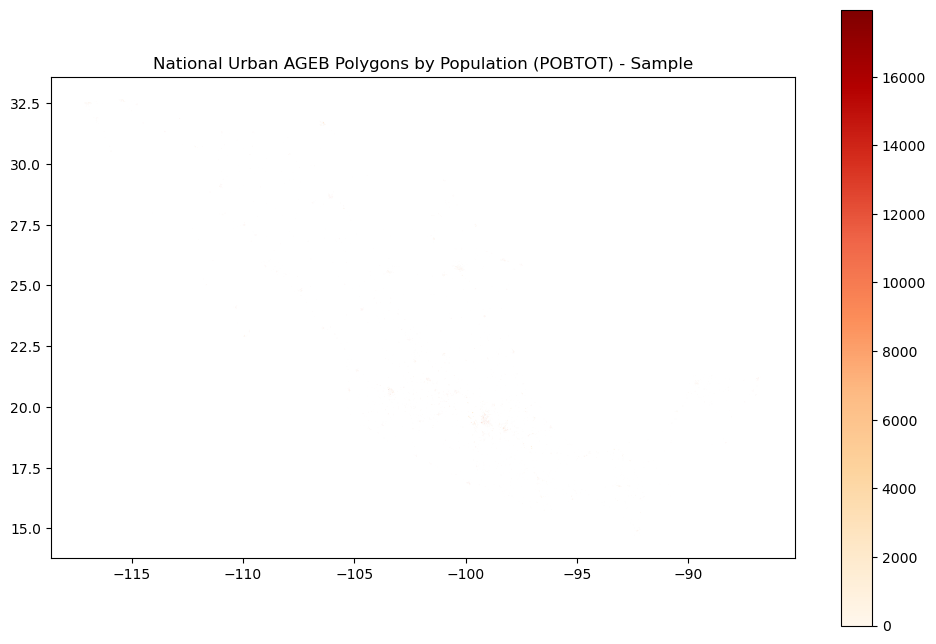


Sample merged row:
        join_key         NOM_MUN  POBTOT  GRAPROES  \
0  010010001216A  Aguascalientes    2657      10.7   

                                            geometry  
0  POLYGON ((-102.27058 21.87363, -102.27083 21.8...  

Exported full GeoParquet : ../data/processed/ageb_merged/national_ageb_geo_full.parquet
Exported QA report       : ../data/processed/ageb_merged/national_ageb_merge_qa.csv


In [15]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from pathlib import Path

# Load national AGEB stats
parquet_path = '../data/processed/ageb_total/national_ageb.parquet'
national_ageb = pd.read_parquet(parquet_path)
print(f"Loaded stats table with {len(national_ageb):,} rows.")

# Load national AGEB shapes
shp_dir = '../data/raw/inegi_shapes/2024_1_00_A'
shp_base = '2024_1_00_A'
shp_path = Path(shp_dir) / f"{shp_base}.shp"

if not shp_path.exists():
    raise FileNotFoundError(f"Shapefile not found: {shp_path}")

ageb_shp = gpd.read_file(shp_path).to_crs('EPSG:4326')
print(f"Loaded shape table with {len(ageb_shp):,} polygons.")
print("SHP columns:", ageb_shp.columns.tolist())

# Build join key in shapes
if 'CVEGEO' in ageb_shp.columns:
    ageb_shp['join_key'] = ageb_shp['CVEGEO'].astype(str).str.zfill(13)
elif {'CVE_ENT', 'CVE_MUN', 'CVE_LOC', 'CVE_AGEB'}.issubset(ageb_shp.columns):
    ageb_shp['join_key'] = (
        ageb_shp['CVE_ENT'].astype(str).str.zfill(2)
        + ageb_shp['CVE_MUN'].astype(str).str.zfill(3)
        + ageb_shp['CVE_LOC'].astype(str).str.zfill(4)
        + ageb_shp['CVE_AGEB'].astype(str).str.zfill(4)
    )
else:
    raise ValueError('No valid key columns found in shapefile to construct join_key.')

# Build join key in stats
if 'CVEGEO' not in national_ageb.columns:
    raise ValueError("Stats parquet must contain 'CVEGEO'.")
national_ageb['join_key'] = national_ageb['CVEGEO'].astype(str).str.zfill(13)

# 1) Merge integrity checks
dup_shp = ageb_shp['join_key'].duplicated().sum()
dup_stats = national_ageb['join_key'].duplicated().sum()
print(f"Duplicate join_key in shapes: {dup_shp:,}")
print(f"Duplicate join_key in stats : {dup_stats:,}")

if dup_shp > 0 or dup_stats > 0:
    raise ValueError('join_key must be unique in both tables before 1:1 merge.')

# 2) Coverage checks before merge
shape_keys = pd.DataFrame({'join_key': ageb_shp['join_key'].dropna().unique()})
stats_keys = pd.DataFrame({'join_key': national_ageb['join_key'].dropna().unique()})
coverage = shape_keys.merge(stats_keys, on='join_key', how='outer', indicator=True)
n_shape_only = (coverage['_merge'] == 'left_only').sum()
n_stats_only = (coverage['_merge'] == 'right_only').sum()
n_both = (coverage['_merge'] == 'both').sum()
print('\nKey coverage summary:')
print(f"Matched keys (both) : {n_both:,}")
print(f"Shape-only keys      : {n_shape_only:,}")
print(f"Stats-only keys      : {n_stats_only:,}")

# 3) Safe 1:1 merge
ageb_geo = ageb_shp.merge(
    national_ageb,
    on='join_key',
    how='inner',
    validate='1:1'
).dropna(subset=['POBTOT'])

print(f"\nMerged features: {len(ageb_geo):,} ({len(ageb_geo)/len(ageb_shp)*100:.1f}% of shapes)")

# 4) Validate SCI-required variables exist and are numeric
sci_required = [
    'GRAPROES', 'POCUPADA', 'VPH_REFRI', 'VPH_PC', 'VPH_AUTOM', 'VPH_LAVAD',
    'VPH_PISODT', 'VPH_AGUADV', 'VPH_C_ELEC', 'VPH_DRENAJ', 'VPH_TELEF',
    'PRO_OCUP_C', 'POB0_14', 'POB65_MAS', 'POBTOT'
    # Context-only fields can still be tracked if available: P3YM_HLI, HOGJEF_F, REL_H_M
]

missing_required = [c for c in sci_required if c not in ageb_geo.columns]
if missing_required:
    print('\nWARNING: Missing SCI variables:')
    print(missing_required)

for c in [c for c in sci_required if c in ageb_geo.columns]:
    ageb_geo[c] = pd.to_numeric(ageb_geo[c], errors='coerce')

null_report = (
    ageb_geo[[c for c in sci_required if c in ageb_geo.columns]]
    .isna()
    .sum()
    .sort_values(ascending=False)
)
print('\nNull counts for SCI variables (top 10):')
print(null_report.head(10))

# 5) Quick reproducible visualization
sample_geo = ageb_geo.sample(min(5000, len(ageb_geo)), random_state=42)
sample_geo.plot(column='POBTOT', cmap='OrRd', legend=True, figsize=(12, 8))
plt.title('National Urban AGEB Polygons by Population (POBTOT) - Sample')
plt.show()

print('\nSample merged row:')
preview_cols = [c for c in ['join_key', 'NOM_MUN', 'POBTOT', 'GRAPROES', 'geometry'] if c in ageb_geo.columns]
print(ageb_geo[preview_cols].head(1))

# 6) Export artifacts: full + QA report
out_dir = Path('../data/processed/ageb_merged')
out_dir.mkdir(parents=True, exist_ok=True)

full_path = out_dir / 'national_ageb_geo_full.parquet'
ageb_geo.to_parquet(full_path, index=False)

qa = pd.DataFrame([
    {
        'n_stats_rows': len(national_ageb),
        'n_shape_rows': len(ageb_shp),
        'n_merged_rows': len(ageb_geo),
        'join_rate_pct': round(len(ageb_geo) / len(ageb_shp) * 100, 2),
        'n_matched_keys': int(n_both),
        'n_shape_only_keys': int(n_shape_only),
        'n_stats_only_keys': int(n_stats_only),
        'dup_join_key_shapes': int(dup_shp),
        'dup_join_key_stats': int(dup_stats)
    }
])
qa_path = out_dir / 'national_ageb_merge_qa.csv'
qa.to_csv(qa_path, index=False)

print(f"\nExported full GeoParquet : {full_path}")
print(f"Exported QA report       : {qa_path}")
